# Platform information

In [2]:
library(benchmarkme)
get_platform_info()$OS.type
get_r_version()$version.string
get_cpu()$model_name;get_cpu()$no_of_cores
get_ram()

[1] "windows"

[1] "R version 3.5.1 (2018-07-02)"

[1] "Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz"

[1] 8

8.59 GB

# Parallel computation

In [3]:
library(doParallel)
library(foreach)
cl<-makeCluster(8) 

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


# Loading data and sort markers

In [4]:
geno <-read.table("Hetero_realigned_cov10_filtered3.raw", row.names=1, header=T)
colnames(geno)<-1:3928
rownames(geno)<-1:240
lin_map<-read.table("raw.map")
lin_map["id"]=1:3928
m<-lin_map[order(lin_map$V2),]
sortM<-m[order(m$V1),]
sortgeno<-geno[,sortM$id]
colnames(sortgeno)<-1:3928

In [5]:
x <- as.matrix(sortgeno)-1   
pheno <- read.csv("./2017heteroPheno.csv", header=T)
attach(pheno)
#tbcw=sqrt(pheno$bcw+1), data normalization
data <- data.frame(tbcw=sqrt(pheno$bcw+1),length=pheno$length,gid=1:240)

# Parameters for cross validation

In [6]:
repeats <- 10
n.fold <- 5 
n.samples <- length(pheno$bcw) 
n.makers<-length(x[1,])
CM<-7

# Marker density 

In [13]:
library("rrBLUP")
y<-seq(0.1,1,0.1)
num.makers<-round(n.makers*y)
result = matrix(nrow = length(y),ncol = repeats*n.fold)
registerDoParallel(cl)
for(p in 1:length(y)) { 
  set.seed(100+3*p+1)
  idxy<-sample(n.makers,num.makers[p])
  xy<-x[,idxy]
  A <- A.mat(xy, n.core=8)
  row.names(A)=1:n.samples;colnames(A)=1:n.samples
  GBLUP<-foreach(j=1:repeats,.combine = "rbind") %do% {
        set.seed(100+3*j+1)
        id <- sample(1:n.samples %% n.fold) + 1 
        foreach(i=1:n.fold,.packages="rrBLUP") %dopar% {
         bcw_test <- data
         bcw_test$tbcw[id == i] <- NA
         res <- kin.blup(bcw_test, K=A, geno="gid", pheno="tbcw")
         cor(data$tbcw[id==i],res$pred[id==i])  
      }
    } 
   result[p, ]<-unlist(GBLUP)
}
stopImplicitCluster()

In [14]:
Acc_mean<-apply(result,1,function(x) round(mean(x),digits = 3))
Acc_SE<-apply(result,1,function(x) round(sd(x)/sqrt(repeats*n.fold),digits = 3))
(all<-data.frame(num.makers,Acc_mean,Acc_SE))

num.makers,Acc_mean,Acc_SE
393,0.136,0.017
786,0.197,0.018
1178,0.273,0.017
1571,0.254,0.017
1964,0.268,0.017
2357,0.288,0.016
2750,0.279,0.017
3142,0.275,0.017
3535,0.290,0.016
3928,0.284,0.017


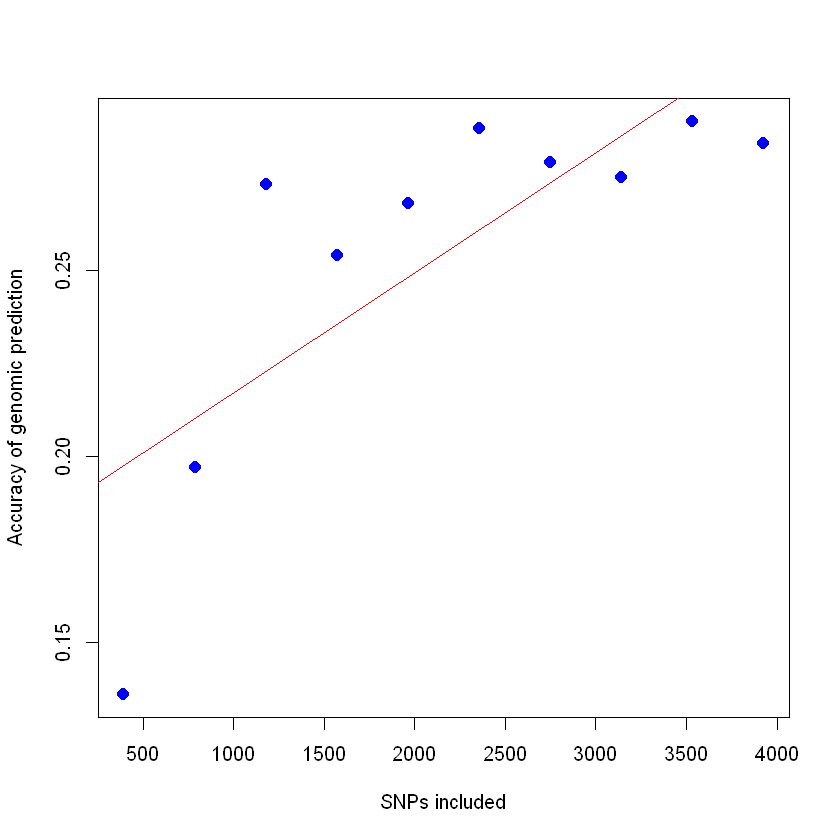

In [15]:
plot(num.makers,Acc_mean,pch = 16, cex = 1.3, col = "blue",ylab="Accuracy of genomic prediction",xlab="SNPs included")
abline(lm(Acc_mean ~ num.makers),col="red")

In [10]:
library("rrBLUP")
y<-seq(0.01,1,0.01)
num.makers<-round(n.makers*y)
result = matrix(nrow = length(y),ncol = repeats*n.fold)
registerDoParallel(cl)
for(p in 1:length(y)) { 
  set.seed(100+3*p+1)
  idxy<-sample(n.makers,num.makers[p])
  xy<-x[,idxy]
  A <- A.mat(xy, n.core=8)
  row.names(A)=1:n.samples;colnames(A)=1:n.samples
  GBLUP<-foreach(j=1:repeats,.combine = "rbind") %do% {
        set.seed(100+3*j+1)
        id <- sample(1:n.samples %% n.fold) + 1 
        foreach(i=1:n.fold,.packages="rrBLUP") %dopar% {
         length_test <- data
         length_test$length[id == i] <- NA
         res <- kin.blup(length_test, K=A, geno="gid", pheno="length")
         cor(data$length[id==i],res$pred[id==i])  
      }
    } 
   result[p, ]<-unlist(GBLUP)
}
stopImplicitCluster()

In [11]:
Acc_mean<-apply(result,1,function(x) round(mean(x),digits = 3))
Acc_SE<-apply(result,1,function(x) round(sd(x)/sqrt(repeats*n.fold),digits = 3))
(all<-data.frame(num.makers,Acc_mean,Acc_SE))

num.makers,Acc_mean,Acc_SE
39,0.147,0.021
79,0.212,0.019
118,0.364,0.018
157,0.322,0.017
196,0.424,0.017
236,0.344,0.019
275,0.291,0.025
314,0.380,0.018
354,0.410,0.020
393,0.341,0.020


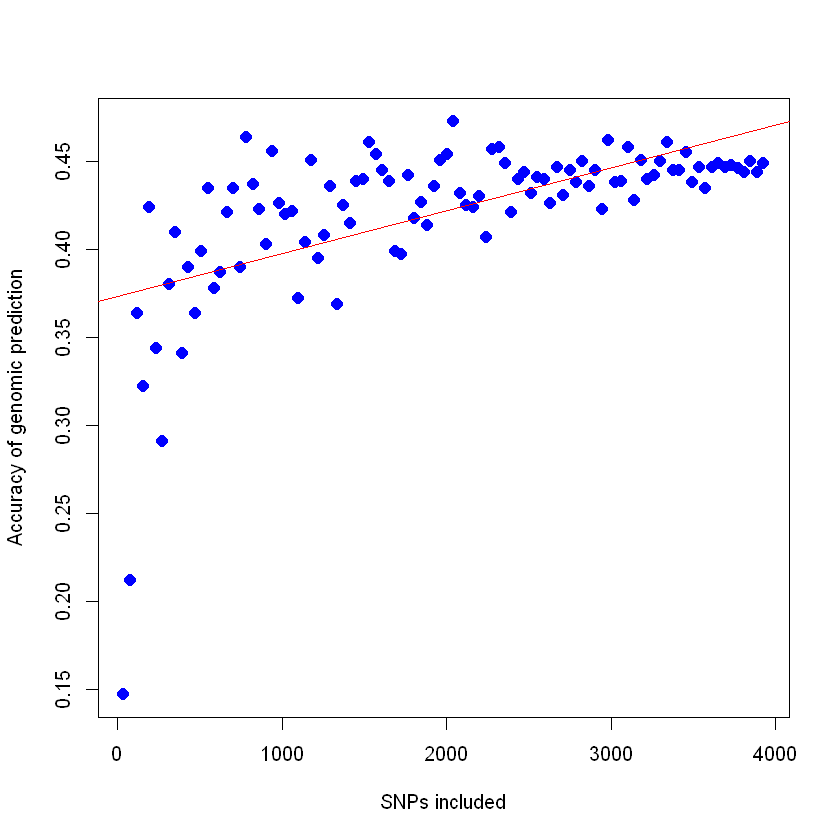

In [12]:
plot(num.makers,Acc_mean,pch = 16, cex = 1.3, col = "blue",ylab="Accuracy of genomic prediction",xlab="SNPs included")
abline(lm(Acc_mean ~ num.makers),col="red")

# I change the seed of sample, but result is similar

In [30]:
library("rrBLUP")
y<-seq(0.01,1,0.01)
num.makers<-round(n.makers*y)
result = matrix(nrow = length(y),ncol = repeats*n.fold)
registerDoParallel(cl)
for(p in 1:length(y)) { 
  set.seed(100+3*p+2)
  idxy<-sample(n.makers,num.makers[p])
  xy<-x[,idxy]
  A <- A.mat(xy, n.core=8)
  row.names(A)=1:n.samples;colnames(A)=1:n.samples
  GBLUP<-foreach(j=1:repeats,.combine = "rbind") %do% {
        set.seed(100+3*j+1)
        id <- sample(1:n.samples %% n.fold) + 1 
        foreach(i=1:n.fold,.packages="rrBLUP") %dopar% {
         bcw_test <- data
         bcw_test$tbcw[id == i] <- NA
         res <- kin.blup(bcw_test, K=A, geno="gid", pheno="tbcw")
         cor(data$tbcw[id==i],res$pred[id==i])  
      }
    } 
   result[p, ]<-unlist(GBLUP)
}
stopImplicitCluster()

In [ ]:
Acc_mean<-apply(result,1,function(x) round(mean(x),digits = 3))
Acc_SE<-apply(result,1,function(x) round(sd(x)/sqrt(repeats*n.fold),digits = 3))
(all<-data.frame(num.makers,Acc_mean,Acc_SE))

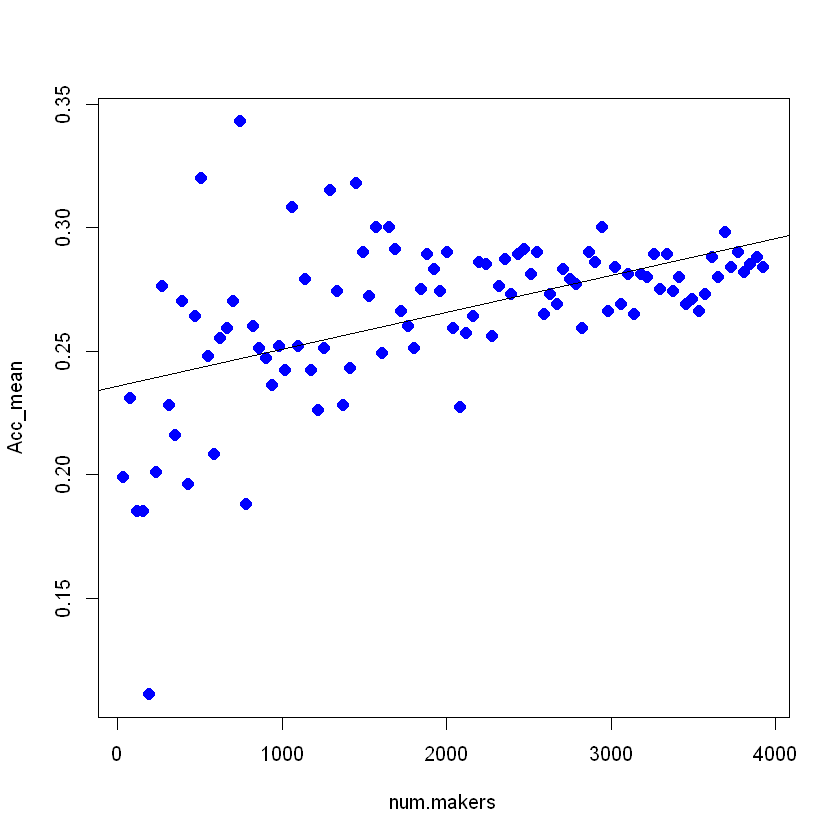

In [32]:
plot(num.makers,Acc_mean,pch = 16, cex = 1.3, col = "blue")
abline(lm(Acc_mean ~ num.makers))

# I think marker density can be reduced by selecting the SNP

# I rank SNP of high genetic effect using bayes B

In [127]:
library("BGLR")
fmBB=BGLR(y=sqrt(bcw+1),ETA=list(list(X=x,model='BayesB')),nIter=2000,burnIn=1000,saveAt='BB_')

[1] '1.0.5'


#--------------------------------------------------------------------#
#        _\\|//_                                                     #
#       (` o-o ')      BGLR v1.0.5                                   #
#------ooO-(_)-Ooo---------------------------------------------------#
#                      Bayesian Generalized Linear Regression        #
#                      Gustavo de los Campos, gdeloscampos@gmail.com #
#    .oooO     Oooo.   Paulino Perez-Rodriguez, perpdgo@gmail.com    #
#    (   )     (   )   Agust, 2016                                   #
#_____\ (_______) /_________________________________________________ #
#      \_)     (_/                                                   #
#                                                                    #
#------------------------------------------------------------------- #

  R2 in LP 1 was missing and was set to 0.5
  DF in LP 1 was missing and was set to 5
  probIn in LP 1 was missing and was set to 0.5
  Counts in 

In [157]:
bhat<-matrix(nrow=2,ncol=3928)
bhat[1,]<-seq.int(1,3928,1)
bhat[2,]<-fmBB$ETA[[1]]$b
bhat_sorted <- bhat[,order(abs(bhat[2,]),decreasing = TRUE)]

In [23]:
xn<-sortgeno[ ,bhat_sorted[1,1:250][order(bhat_sorted[1,1:250])]]

In [34]:
library("synbreed")
pheno <- read.csv("./2017heteroPheno.csv", header=T)
pheno=data.frame(id=1:240,pheno=pheno$bcw)
lin_map<-read.table("./raw.map")
lin_map_xn<-lin_map[bhat_sorted[1,1:250][order(bhat_sorted[1,1:250])],]
colnames(lin_map_xn)<-c("chr","pos")
rownames(lin_map_xn)<-colnames(xn)
gp<-create.gpData(pheno=pheno,geno=xn,map=lin_map_xn)

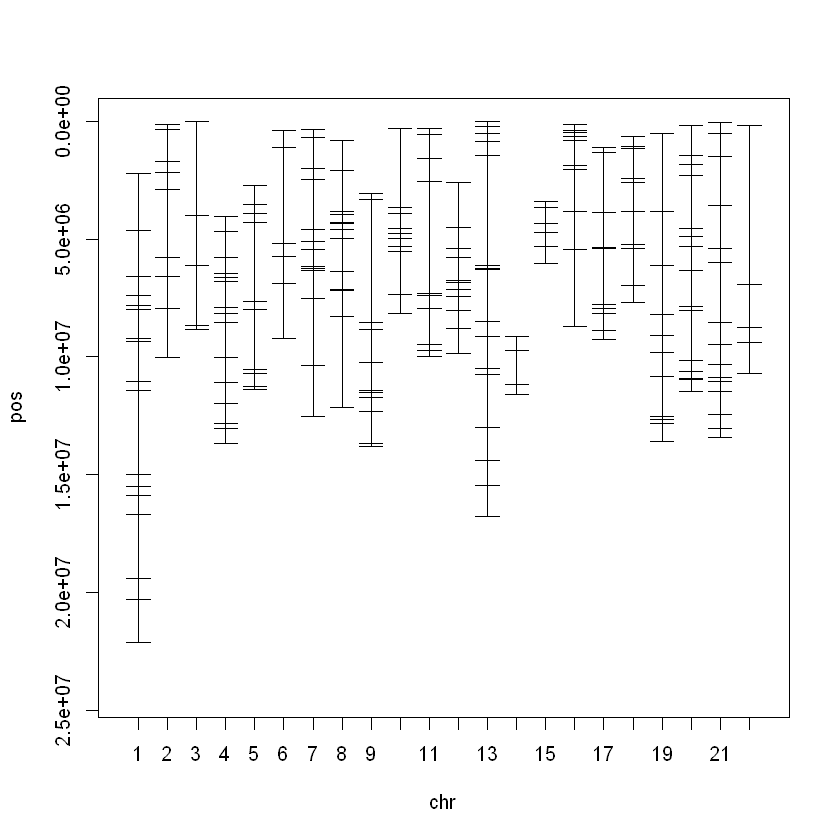

In [35]:
plotGenMap(gp,nMarker=FALSE)

# Accuracy among various panels of makers with high genetic effect (Pearson's r)

In [233]:
high_effect<-c(seq(10,3920,10),3928)
result = matrix(nrow = length(high_effect),ncol = repeats*n.fold)
registerDoParallel(cl)
for (p in 1:length(high_effect)){  
   num_high_effect<-high_effect[p]
   marker_selected<-bhat_sorted[1,1:num_high_effect]
   panel_selected<-x[,marker_selected]
   A <- A.mat(panel_selected, n.core=8)
  row.names(A)=1:n.samples;colnames(A)=1:n.samples
   GBLUP<-foreach(j=1:repeats,.combine = "rbind") %do% {
        set.seed(100+3*j+1)
        id <- sample(1:n.samples %% n.fold) + 1 
        foreach(i=1:n.fold,.packages="rrBLUP") %dopar% {
         bcw_test <- data
         bcw_test$tbcw[id == i] <- NA
         res <- kin.blup(bcw_test, K=A, geno="gid", pheno="tbcw")
         cor(data$tbcw[id==i],res$pred[id==i])  
        }
       }
   result[p,] <- unlist(GBLUP)
  }
stopImplicitCluster()  

In [234]:
Acc_mean<-apply(result,1,function(x) round(mean(x),digits = 3))
Acc_SE<-apply(result,1,function(x) round(sd(x)/sqrt(repeats*n.fold),digits = 3))
(all<-data.frame(high_effect,Acc_mean,Acc_SE))

high_effect,Acc_mean,Acc_SE
10,0.499,0.014
20,0.619,0.011
30,0.668,0.010
40,0.685,0.010
50,0.707,0.010
60,0.735,0.009
70,0.752,0.009
80,0.755,0.009
90,0.775,0.008
100,0.782,0.008


# plot show that if we choose the panel of 250 makers with highest genetic value, we could get maximum accuracy of GP

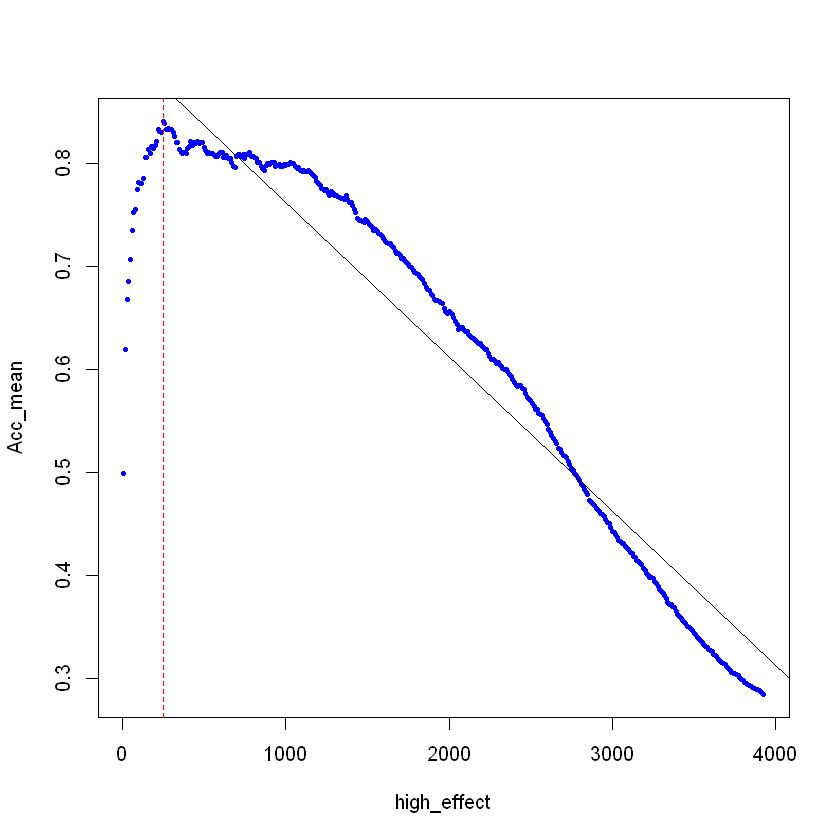

In [235]:
plot(high_effect,Acc_mean,pch = 16, cex = 0.5, col = "blue")
abline(lm(Acc_mean ~ high_effect))
abline(v=all[all[,2]==max(all[,2]),1], col="red",lty = 2)

In [243]:
#panel wit maximum accuracy
all[all[,2]==max(all[,2]),]

,high_effect,Acc_mean,Acc_SE
25,250,0.841,0.006


# Try other model using this panel, still get high accuracy

In [239]:
marker_selected<-bhat_sorted[1,1:250]
panel_selected<-x[,marker_selected]
registerDoParallel(cl)
system.time({
BC <- foreach(j=1:repeats,.combine = "rbind") %do% {
        set.seed(100+3*j+1)
        id <- sample(1:n.samples %% n.fold) + 1 
        foreach(i=1:n.fold,.packages="BGLR") %dopar% {
         bcw_test <- data
         bcw_test$tbcw[id == i] <- NA
         fmBC=BGLR(y=bcw_test$tbcw,ETA=list(list(X=panel_selected,model='BayesC')),nIter=2000,burnIn=1000)
         cor(data$tbcw[id == i],fmBC$yHat[id == i])
         }  
    }
})
stopImplicitCluster()  

   user  system elapsed 
   0.20    0.12    6.81 

In [240]:
mean(unlist(BC))

[1] 0.8309758

# I think the result indicate a pre-selection of high effect marker, could increase  the accuracy of GP

In [12]:
bhat<-matrix(nrow=2,ncol=3928)
bhat[1,]<-seq.int(1,3928,1)
registerDoParallel(cl)
BC <- foreach(j=1:repeats,.combine = "rbind") %do% {
        id <- sample(1:n.samples %% n.fold) + 1 
         foreach(i=1:n.fold,.packages="BGLR") %dopar% {
         bcw_test <- data
         bcw_test$tbcw[id == i] <- NA
         fmBC=BGLR(y=bcw_test$tbcw,ETA=list(list(X=x,model='BayesC')),nIter=2000,burnIn=1000)
         bhat[2,]<-fmBC$ETA[[1]]$b
         bhat_sorted <- bhat[,order(abs(bhat[2,]),decreasing = TRUE)]
         num_high_effect<-1000
         marker_selected<-bhat_sorted[1,1:num_high_effect]
         panel_selected<-x[,marker_selected]
         fmBC=BGLR(y=bcw_test$tbcw,ETA=list(list(X=panel_selected,model='BayesC')),nIter=2000,burnIn=1000)
         cor(data$tbcw[id == i],fmBC$yHat[id == i])
         }  
    }
stopImplicitCluster()  

In [14]:
mean(unlist(BC))

[1] 0.2409838